# Tests! (does my code work?)

## Test construtors in POMDP

In [68]:
using Plots
using Distributions
using Statistics
theme(:wong2)

In [69]:
include("POMDPs.jl")

Main.POMDPs

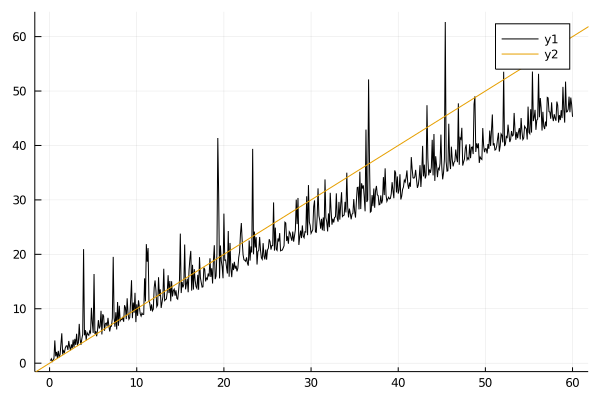

In [70]:
include("Examples.jl")
# function T!(x,f)
#     Examples.partially_observed_fishery_T!(x,f,Examples.partiallyObservedFishery_pars)
# end
T! = (x,f) -> Examples.partially_observed_fishery_T!(x,f,Examples.partiallyObservedFishery_pars)
R = (x,f) -> Examples.partially_observed_fishery_R!(x,f,Examples.partiallyObservedFishery_pars)
G = (y,x,f) -> Examples.partially_observed_fishery_G(x,y,f,Examples.partiallyObservedFishery_pars)
G_sim = (x,f) -> Examples.partially_observed_fishery_G_sim(x,f,Examples.partiallyObservedFishery_pars)
delta = 0.93
actions= [[1.0]]
obs = [[1.0]]
partiallyObservableFishery = POMDPs.init(T!, R, G_sim, G, delta, actions, obs)

x = log.(0.1:0.1:60)
x_copy = log.(0.1:0.1:60)
y = broadcast(x -> partiallyObservableFishery.T!([x], [0.0])[1] ,x)
Plots.plot(exp.(x_copy),exp.(y) )
Plots.abline!(1,0)

# Test `ParticleFilters.jl`
To start use base methods for patially observed systems

In [ ]:
import Pkg; Pkg.add("StatsBase")
include("ParticleFilters.jl")

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


Main.ParticleFilters

## Initalize a particle filter object

In [ ]:

PF = ParticleFilters.init(500,1) # generate particle filter object
prior = Distributions.Normal(3.5,0.5) # set prior distribution
broadcast(i -> PF.samples[i] .= rand(prior,1)[1], 1:PF.N) # sample from prior
print(" ")

# Generate a time series of observaitons 

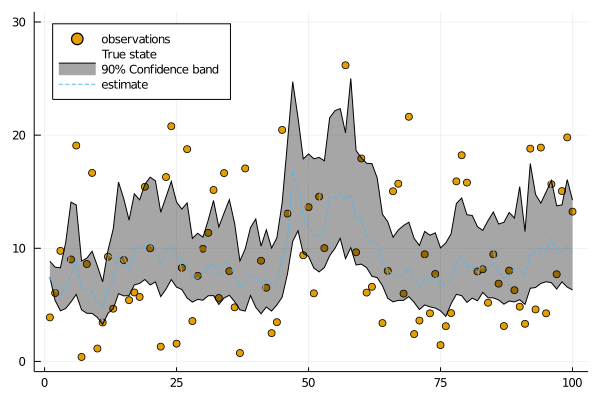

In [ ]:
x = [0.5]
t_ = 100
yt = broadcast(i -> zeros(2),1:t_)
xt = zeros(t_)
for t in 1:t_
    xt[t] = x[1]
    yt[t] .= partiallyObservableFishery.G_sim(x,[0.1])
    partiallyObservableFishery.T!(x, [0.1])
end 
# plot observations and true abundnaces 
p1 = Plots.scatter(broadcast(i -> exp(yt[i][1]),1:t_), color = 2, ylim = [0,30], label = "observations")
p1 = Plots.plot!(p1, exp.(xt), color = "white", label = "True state")

x_hat, x_lower, x_upper = zeros(t_), zeros(t_), zeros(t_)
for t in 1:t_
    ParticleFilters.bayes_update!(PF,partiallyObservableFishery.G,yt[t],[0.1])
    ParticleFilters.resample!(PF)
    x_hat[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
    x_lower[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.05)
    x_upper[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.95)
    ParticleFilters.time_update!(PF,partiallyObservableFishery.T!,[0.1])
end 


p1 = Plots.plot!(p1,exp.(x_lower), fillrange = exp.(x_upper), 
    fillalpha = 0.35,  c = 1,
    label = "90% Confidence band", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper), c=1, label = "")
p1 = Plots.plot!(p1, exp.(x_hat), c = 3, linestyle =:dash, label = "estimate")
p1

# Test unscented Kalman Filters

## Initailize `POMDP_KalmanFilter`

In [155]:
# load KalmandFilters.jl and Examples.jl
using KalmanFilters
include("Examples.jl")
include("POMDPs.jl")
include("ParticleFilters.jl")
# initianize POMDP object
T_! = (x,f) -> Examples.unknown_growth_rate_T!(x,f,(0.99,0.01, 1.0))
T_ = (x,f) -> Examples.unknown_growth_rate_T(x,f,(0.99,0.01, 1.0))
R = (x,f) -> sum(x)
Sigma_N = Examples.Sigma_N
H = (x,a, obs) -> Examples.H * x
Sigma_O = (a,o) -> reshape(Examples.Sigma_O(o),1,1)
delta = 0.95
unknownGrowthRate = POMDPs.init(T_!,T_,R,H,Sigma_N,Sigma_O,delta, [[0.1]], [[1.0]])
print(" ")

1
[1.0]
 

## Comapre Particle filter and Kalman filter resutls

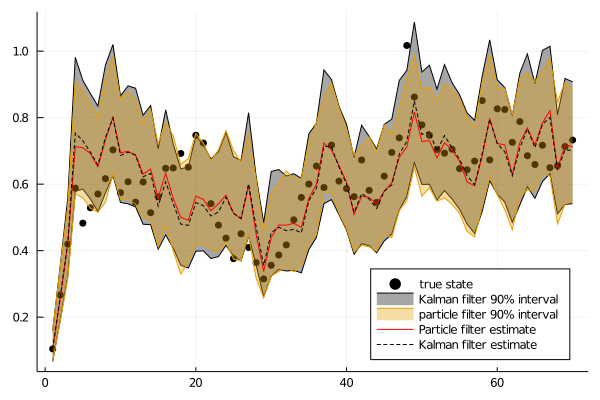

In [172]:
#### generate time series ####
a = [0.15]
obs = [0.05]
N_ = 70
yt = zeros(N_)
xt = zeros(N_)
x = [-3.5,1.5]
for t in 1:N_
    x = unknownGrowthRate.T_sim!(x,a)
    xt[t] = x[1]
    yt[t] = unknownGrowthRate.G_sim(x,a,obs)[1]
end 
#p1 = Plots.scatter(exp.(yt), c=1)
p1 = Plots.scatter(exp.(xt), c = 1, label = "true state")




#### initalize filters ####
# prior distribution 
x0, P0 = [-3.5,1.5],[1.0 0.0; 0.0 0.0025]

# init particle filter
PF = ParticleFilters.init(1000,2) # generate particle filter object
prior = Distributions.MvNormal(x0,P0) # set prior distribution
broadcast(i -> PF.samples[i] .= reshape(rand(prior,1),2), 1:PF.N) # sample from prior

# step 1 to init KalmanFilter object
uKF = KalmanFilters.time_update(x0,P0,
                    x ->unknownGrowthRate.T(x,a),  unknownGrowthRate.Sigma_N)

uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),yt[1],
                    x ->  unknownGrowthRate.H(x,a, obs),unknownGrowthRate.Sigma_O(a, obs))

# update Particle Filter
ParticleFilters.time_update!(PF,unknownGrowthRate.T_sim!,a)
ParticleFilters.bayes_update!(PF,unknownGrowthRate.G,yt[1],a,obs)
ParticleFilters.resample!(PF)
print(" ")


x = get_state(uKF)
P = get_covariance(uKF)

### accumulators ###

# kalman filter
x_hat = zeros(N_)
a_hat = zeros(N_)
x_lower, x_upper = zeros(N_),zeros(N_)
a_lower, a_upper = zeros(N_),zeros(N_)

x_hat[1] = x[1]
a_hat[1] = x[2]

x_lower[1], x_upper[1] = x[1] - 2*sqrt(P[1,1]), x[1] + 2*sqrt(P[1,1])
a_lower[1], a_upper[1] = x[2] - 2*sqrt(P[2,2]), x[2] + 2*sqrt(P[2,2])

# particle filter
x_hat_pf = zeros(N_)
a_hat_pf = zeros(N_)
x_lower_pf, x_upper_pf = zeros(N_),zeros(N_)
a_lower_pf, a_upper_pf = zeros(N_),zeros(N_)

x_hat_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
a_hat_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.5)

x_lower_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.025)
x_upper_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.975)
a_lower_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.025)
a_upper_pf[1] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.975)

#### iterate ove time series ####
for t in 2:N_
    # update Kalman Filter
    uKF = KalmanFilters.time_update(get_state(uKF),get_covariance(uKF),
                        x ->unknownGrowthRate.T(x,[0.1]),  unknownGrowthRate.Sigma_N)
    
    uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),yt[t],
                           x ->  unknownGrowthRate.H(x,a, obs),unknownGrowthRate.Sigma_O(a,obs))
    
    
    # update Particle Filter
    ParticleFilters.time_update!(PF,unknownGrowthRate.T_sim!,a)
    ParticleFilters.bayes_update!(PF,unknownGrowthRate.G,yt[t],a,obs)
    ParticleFilters.resample!(PF)
    
    
    
    x = get_state(uKF)
    P = get_covariance(uKF)
    x_hat[t] = x[1]
    a_hat[t] = x[2]

    x_lower[t], x_upper[t] = x[1] - 2*sqrt(P[1,1]), x[1] + 2*sqrt(P[1,1])
    a_lower[t], a_upper[t] = x[2] - 2*sqrt(P[2,2]), x[2] + 2*sqrt(P[2,2])
    
    # particel filter data     
    x_hat_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.5)
    x_lower_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.025)
    x_upper_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][1],1:PF.N),0.975)
    
    
    a_hat_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.5)
    a_lower_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.025)
    a_upper_pf[t] = Statistics.quantile(broadcast(i->PF.samples[i][2],1:PF.N),0.975)
end 


p1 = Plots.plot!(p1,exp.(x_lower), fillrange = exp.(x_upper), 
    fillalpha = 0.35,  c = 1,
    label = "Kalman filter 90% interval", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper), c=1, label = "")


p1 = Plots.plot!(p1,exp.(x_lower_pf), fillrange = exp.(x_upper_pf), 
    fillalpha = 0.35,  c = 2,
    label = "particle filter 90% interval", legend = :topleft)
p1 = Plots.plot!(p1,exp.(x_upper_pf), c=2, label = "")
p1 = Plots.plot!(p1, exp.(x_hat_pf), color = "red", label = "Particle filter estimate",legend =:bottomright)
p1 = Plots.plot!(p1, exp.(x_hat), color = "black", linestyle =:dash, label = "Kalman filter estimate")

p1

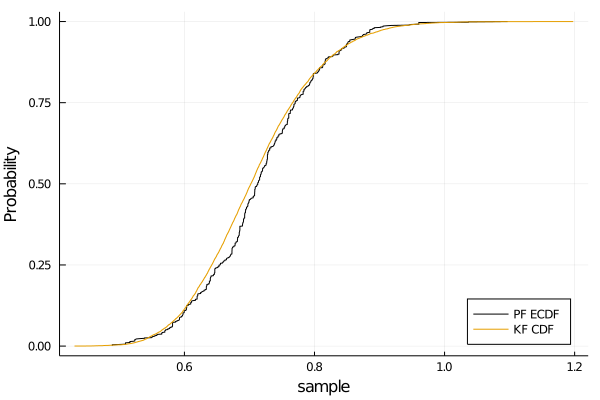

In [173]:
x1 = broadcast(x -> x[1], PF.samples)
n = length(x1)

p2 = Plots.plot(sort(exp.(x1)), (1:n)./n, 
    xlabel = "sample", ylabel = "Probability", 
     label = "PF ECDF")
d = Distributions.Normal(x[1],sqrt(P[1,1]))
x1 = rand(d, 10000)
n = length(x1)
Plots.plot!(sort(exp.(x1)), (1:n)./n, 
    xlabel = "sample", ylabel = "Probability", 
    label = "KF CDF",legend =:bottomright)
p2

In [169]:

function KalmanFilter(y)
    uKF = KalmanFilters.time_update(x0, P0,
                            x ->unknownGrowthRate.T(x,a),  unknownGrowthRate.Sigma_N)

    uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),y,
                               x ->  unknownGrowthRate.H(x,a,obs),unknownGrowthRate.Sigma_O(a,obs))
end 

function ParticleFilter(y)
    ParticleFilters.time_update!(PF,unknownGrowthRate.T_sim!,[0.1])
    ParticleFilters.bayes_update!(PF,unknownGrowthRate.G,y,a, obs)
    #ParticleFilters.resample!(PF)
end 

KalmanFilter(yt[40])
ParticleFilter(yt[40])
print(" ")

@time ParticleFilter(yt[40])
@time KalmanFilter(yt[40])

   0.001944 seconds (22.00 k allocations: 1.252 MiB)
  0.000084 seconds (102 allocations: 7.500 KiB)


KalmanFilters.SPMeasurementUpdate{Array{Float64,1},Array{Float64,2},KalmanFilters.TransformedSigmaPoints{Float64,Array{Float64,1},Array{Float64,2},WanMerweWeightingParameters},Array{Float64,1},Array{Float64,2},Array{Float64,2}}([-0.43428098452765407, 1.500030043577391], [0.04712438305692146 0.00012628300620076867; 0.00012628300620076867 0.02244470426912782], [-2.31131664570421 -2.310036506134935 … -2.3125967852734846 -2.31131664570421], [1.9915758461060749], [0.869378658387912], [0.9424876611385563; 0.0025256601240157264])

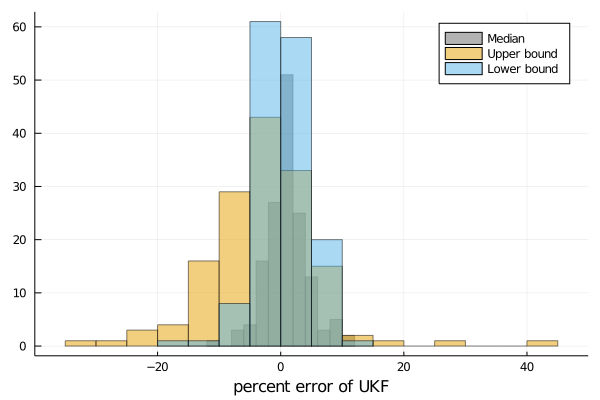

In [170]:
Plots.histogram(100 *(x_hat .- x_hat_pf)./mean(x_hat_pf),
    xlab = "percent error of UKF", label = "Median", alpha = 0.3)
Plots.histogram!(100 *(x_upper .- x_upper_pf)./mean(x_upper_pf), 
    label = "Upper bound", alpha = 0.5)
Plots.histogram!(100 *(x_lower .- x_lower_pf)./mean(x_lower_pf), 
    label = "Lower bound", alpha = 0.5)

# Test `MvGaussHermite`
## to solveintegrals for bellman opperator

In [174]:
import Pkg; Pkg.add("FastGaussQuadrature")

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [175]:
using FastGaussQuadrature
using LinearAlgebra
using IterTools
include("MvGaussHermite.jl")

Main.MvGaussHermite

# Test 2 dimensional GH quadrature 

In [176]:
Cov = [0.25 -0.2;-0.2 0.3] .* 2.0
m = 4
Quad = MvGaussHermite.init(m, [0,0.0],Cov)

Main.MvGaussHermite.quadrature([0.01605018360933761, 0.04668426114935483, 0.04668426114935483, 0.01605018360933761, 0.04668426114935483, 0.13578786960376119, 0.13578786960376119, 0.04668426114935483, 0.04668426114935483, 0.13578786960376119, 0.13578786960376119, 0.04668426114935483, 0.01605018360933761, 0.04668426114935483, 0.04668426114935483, 0.01605018360933761], AbstractArray{Float64,1}[[1.5082680645200224, -1.7085392442759781], [1.2225977965107804, -0.9238325769074363], [0.9563954851739278, -0.19260237213097525], [0.6707252171646858, 0.5921042952375665], [0.7650540346530617, -1.327744074078104], [0.47938376664381965, -0.5430374067095622], [0.21318145530696717, 0.18819279806689887], [-0.07248881270227481, 0.9728994654354406], [0.07248881270227481, -0.9728994654354406], [-0.21318145530696717, -0.18819279806689887], [-0.47938376664381965, 0.5430374067095622], [-0.7650540346530617, 1.327744074078104], [-0.6707252171646858, -0.5921042952375665], [-0.9563954851739278, 0.1926023721309752

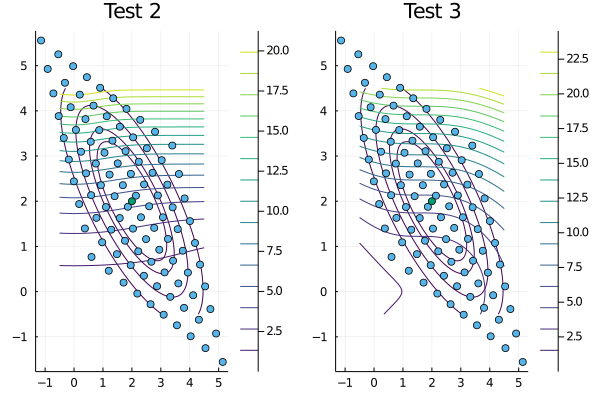

┌ Warning: Multiple series with different levels share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /Users/johnbuckner/.julia/packages/Plots/SjqWU/src/backends/gr.jl:498
┌ Warning: Multiple series with different levels share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /Users/johnbuckner/.julia/packages/Plots/SjqWU/src/backends/gr.jl:498


In [177]:

# prune 
theta = 0.00001 / m^2
# covariance matrix and transform
y_hat = [2.0,2.0]
Cov = [0.25 -0.2;-0.2 0.3] .* 2.0
m = 10
Quad = MvGaussHermite.init(m,y_hat , Cov)


nodes_x = broadcast(i -> Quad.nodes[i][1], 1:Quad.n)
nodes_y = broadcast(i -> Quad.nodes[i][2], 1:Quad.n)

xs = -0.5:0.025:4.5
ys = -0.5:0.025:4.5
dsn = Distributions.MvNormal(y_hat, Cov)
pdf_ = (x,y) -> pdf(dsn, [x,y])
function ftest1(x)
    return x[1]+x[2] + x[1]*x[2] + x[1]^2
end 

function ftest2(x)
    return sum(sin(4*x[1]*x[2])*cos(x[2])+x[1])
end 

function ftest2(x)
    return exp(-0.05*(x[1]*x[2])^2)
end 

function ftest3(x)
    return sum(x[1]+x[2]^2 + cos(3*x[2]*x[1]))
end 
        
        
function ftest2(x,y)
    x = [x,y]
    return exp(-0.05*(x[1]*x[2])^2) + x[2]^2
end 
            
function ftest3(x,y)
    x = [x,y]
    return sum(x[1]+x[2]^2 + cos(x[1]))
end 
p1 = Plots.contour(xs, ys, pdf_, fill=false, levels = [0.1,0.01,0.05,0.001])
Plots.contour!(xs, ys, ftest2, fill=false)

Plots.scatter!(nodes_x,nodes_y)
Plots.scatter!([y_hat[1]], [y_hat[2]], legend = false, title = "Test 2")

p2 = Plots.contour(xs, ys, pdf_, fill=false, levels = [0.1,0.01,0.05,0.001])
Plots.contour!(xs, ys, ftest3, fill=false)

Plots.scatter!(nodes_x,nodes_y)
Plots.scatter!([y_hat[1]], [y_hat[2]], legend = false, title = "Test 3")
plot(p1,p2)

## Compare computed expctations for three test functions
### using `MvGaussHermite.jl` and Montecarlo integration

In [178]:
### compare montecarlo and Gauss Hermite 
# function 1
N_mc = 100000
mcf1 = sum(ftest1.(broadcast(i -> rand(dsn, 1), 1:N_mc)))/N_mc
ghf1 = MvGaussHermite.expected_value(ftest1, Quad)
print("test one Montecarlo: " , mcf1, "\n")
print("test one Gauss Hermite: " , ghf1, "\n")
print("percent diference: " , round((mcf1-ghf1)/mcf1*100,digits = 2), "% \n")
print("\n")
# function 2
mcf2 = sum(ftest2.(broadcast(i -> rand(dsn, 1), 1:N_mc)))/N_mc
ghf2 = MvGaussHermite.expected_value(ftest2, Quad)
print("test two Montecarlo: " , mcf2, "\n")
print("test two Gauss Hermite: " , ghf2, "\n")
print("percent diference: " ,round( (mcf2-ghf2)/mcf2*100, digits = 2), "% \n")
print("\n")
# function 3
mcf3 = sum(ftest3.(broadcast(i -> rand(dsn, 1), 1:N_mc)))/N_mc
ghf3 = MvGaussHermite.expected_value(ftest3, Quad)
print("test three Montecarlo: " , mcf3, "\n")
print("test three Gauss Hermite: " , ghf3, "\n")
print("percent diference: " , round((mcf3-ghf3)/mcf3*100, digits = 2), "% \n")
print("\n")

test one Montecarlo: 12.113805844946796
test one Gauss Hermite: 12.099668942967625
percent diference: 0.12% 

test two Montecarlo: 0.5294409676289479
test two Gauss Hermite: 0.5291421452141204
percent diference: 0.06% 

test three Montecarlo: 6.5861309856418275
test three Gauss Hermite: 6.592737997889056
percent diference: -0.1% 



## Test 3d quadrature

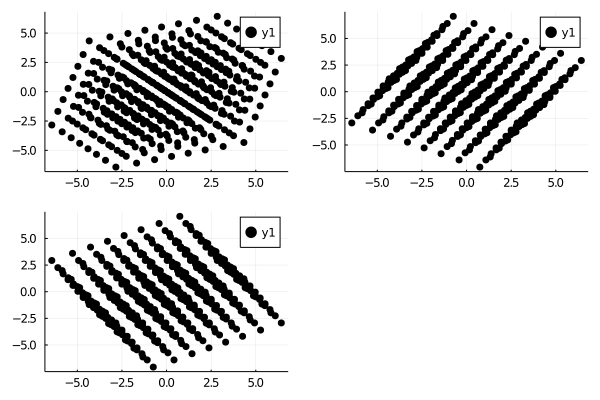

In [179]:
include("MvGaussHermite.jl")
Cov = [2.0 0.5 0.0; 0.5 2.0 0.0; 0.0 0.0 2.0]
y_hat = [0.0, 0.0, 0.0]
m = 8
Quad_3d = MvGaussHermite.init(m, y_hat, Cov)
nodes_x = broadcast(i -> Quad_3d.nodes[i][1], 1:Quad_3d.n)
nodes_y = broadcast(i -> Quad_3d.nodes[i][2]  , 1:Quad_3d.n)
nodes_z = broadcast(i -> Quad_3d.nodes[i][3] , 1:Quad_3d.n)

dsn_3d = Distributions.MvNormal(y_hat, Cov)

p1 = Plots.scatter(nodes_x, nodes_y)
p2 = Plots.scatter(nodes_x, nodes_z)
p3 = Plots.scatter(nodes_y, nodes_z)
plot(p1,p2,p3)

In [180]:
test_f1(x) = x[1]+x[2]+x[3] + x[2]*x[3] +x[2]^2+x[3]^2+x[1]^2
test_f2(x) = x[1]+x[2]+x[3] + sin(2*x[2]*x[3]) + x[1]^2
test_f3(x) = 0.1*x[1]+0.2*x[2]^2+exp(-0.1*x[3]^2) 
Nmc = 1000000
samples = broadcast(i -> rand(dsn_3d, 1), 1:Nmc)
val1_gh = MvGaussHermite.expected_value(test_f1, Quad_3d)
val1_mc = sum(test_f1.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh)/val1_mc*100, digits = 2), "%")
print("\n")

val2_gh = MvGaussHermite.expected_value(test_f2, Quad_3d)
val2_mc = sum(test_f2.(samples))/Nmc 
println("Gauss hermite: ", val2_gh)
println("Montecarlo: ", val2_mc)
println("percent diference: " , round((val2_mc-val2_gh)/val2_mc*100, digits = 2), "%")
print("\n")

val3_gh = MvGaussHermite.expected_value(test_f3, Quad_3d)
val3_mc = sum(test_f3.(samples))/Nmc 
println("Gauss hermite: ", val3_gh)
println("Montecarlo: ", val3_mc)
println("percent diference: " , round((val3_mc-val3_gh)/val3_mc*100, digits = 2), "%")
print("\n")

Gauss hermite: 5.984054326519408
Montecarlo: 5.997777446817467
percent diference: 0.23%

Gauss hermite: 2.0265980561616788
Montecarlo: 1.9960736667744228
percent diference: -1.53%

Gauss hermite: 1.2439913359425414
Montecarlo: 1.2444299147328153
percent diference: 0.04%



## Test 4 dimensions 

In [181]:
include("MvGaussHermite.jl")
Cov = [1.0 0.5 0.0 0.0; 0.5 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
y_hat = [0.0, 0.0, 0.0, 0.0]
m = 8
Quad_4d = MvGaussHermite.init(m, y_hat, Cov)
nodes_x = broadcast(i -> Quad_4d.nodes[i][1], 1:Quad_4d.n)
nodes_y = broadcast(i -> Quad_4d.nodes[i][2], 1:Quad_4d.n)
nodes_z = broadcast(i -> Quad_4d.nodes[i][3], 1:Quad_4d.n)
nodes_w = broadcast(i -> Quad_4d.nodes[i][4], 1:Quad_4d.n)

dsn_4d = Distributions.MvNormal(y_hat, Cov)

p1 = Plots.scatter(nodes_x, nodes_y)
p2 = Plots.scatter(nodes_x, nodes_z)
p3 = Plots.scatter(nodes_x, nodes_w)
p4 = Plots.scatter(nodes_y, nodes_z)
p5 = Plots.scatter(nodes_y, nodes_w)
p6 = Plots.scatter(nodes_z, nodes_w)
plot(p1,p2,p3,p4,p5,p6)

In [182]:
test_f1(x) = x[1]+x[2]+x[3] + x[2]*x[3]*x[4] +x[1]^2+x[2]^2+x[3]^2+x[4]^2
test_f2(x) = x[1]+x[2]+x[3] + sin(2*x[2]*x[3]*x[4])
test_f3(x) = exp(-0.1*x[3]+0.1*x[4]) + cos(x[2]*x[1]) + x[4]*x[3]^2+x[2]^2
Nmc = 1000000
samples = broadcast(i -> rand(dsn_4d, 1), 1:Nmc)
val1_gh = MvGaussHermite.expected_value(test_f1, Quad_4d)
val1_mc = sum(test_f1.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh), digits = 2))
print("\n")

val1_gh = MvGaussHermite.expected_value(test_f2, Quad_4d)
val1_mc = sum(test_f2.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh), digits = 2))
print("\n")

val1_gh = MvGaussHermite.expected_value(test_f3, Quad_4d)
val1_mc = sum(test_f3.(samples))/Nmc 
println("Gauss hermite: ", val1_gh)
println("Montecarlo: ", val1_mc)
println("percent diference: " , round((val1_mc-val1_gh), digits = 2))
print("\n")

Gauss hermite: 3.9889193282634325
Montecarlo: 3.9937211800110943
percent diference: 0.0

Gauss hermite: 1.1102230246251565e-16
Montecarlo: 0.0008891995082593128
percent diference: 0.0

Gauss hermite: 2.68756188460671
Montecarlo: 2.689593082365726
percent diference: 0.0



# Test error propogation through observaton model 

In [183]:
include("BellmanOpperators.jl")
include("MvGaussHermite.jl")
BellmanOpperators.propogate_observation_model([1.0,1.0],[1.0 0.5;0.5 1.0], [1.0 0.1;0.1 1.0])

┌ Warning: Replacing docs for `Main.BellmanOpperators.Policy! :: Tuple{Any,AbstractArray{Float64,1},Function,Any,Any}` in module `Main.BellmanOpperators`
└ @ Base.Docs docs/Docs.jl:227


([1.1, 1.1], [1.11 0.705; 0.705 1.11])

# Test quadrature propogation with linear function
m = 6

In [184]:
m = 6
x_hat = [1.0,1.0]
x_cov = [1.0 0.5; 0.5 1.0]
H_mat = [2.0 0.25;0.25 1.0]
H = x -> H_mat *x
Quad = MvGaussHermite.init_mutable(m, x_hat, x_cov)
mu, Cov = BellmanOpperators.propogate_observation_model(x_hat, x_cov, H, Quad)
println((round.(mu,digits = 4),round.(Cov,digits = 4)))
println(BellmanOpperators.propogate_observation_model(x_hat, x_cov, H_mat))

([2.2453, 1.2474], [4.4808 1.7493; 1.7493 1.289])
([2.25, 1.25], [4.5625 1.78125; 1.78125 1.3125])


In [185]:
m = 5
x_hat = [1.0,1.0]
x_cov = [1.0 0.5; 0.5 1.0]
H_mat = [2.0 0.25;0.25 1.0]
H = x -> H_mat *x
Quad = MvGaussHermite.init_mutable(m, x_hat, x_cov)
mu, Cov = BellmanOpperators.propogate_observation_model(x_hat, x_cov, H, Quad)
println((round.(mu,digits = 4),round.(Cov,digits = 4)))
println(BellmanOpperators.propogate_observation_model(x_hat, x_cov, H_mat))

([2.2358, 1.2421], [4.352 1.6991; 1.6991 1.252])
([2.25, 1.25], [4.5625 1.78125; 1.78125 1.3125])


## Test against non-linear function

In [186]:
include("BellmanOpperators.jl")
include("MvGaussHermite.jl")
include("utils.jl")
f(x) = sin(0.5*x)+0.1*x^2+x
#H = x -> [f(([1.0 1.0] * x)[1])]
mu, Cov = BellmanOpperators.propogate_observation_model(x_hat, x_cov, H, Quad)
println((round.(mu,digits = 3),round.(Cov,digits = 3)))

┌ Warning: Replacing docs for `Main.BellmanOpperators.Policy! :: Tuple{Any,AbstractArray{Float64,1},Function,Any,Any}` in module `Main.BellmanOpperators`
└ @ Base.Docs docs/Docs.jl:227


([2.236, 1.242], [4.352 1.699; 1.699 1.252])


In [187]:
Nmc = 10000
d = Distributions.MvNormal(x_hat,x_cov)
sample = broadcast(i -> rand(d,1),1:Nmc)
vals = H.(sample)
mu = sum(broadcast(v -> v/Nmc, vals))
cov = utils.sum_mat(broadcast(v -> (v .- mu)*transpose(v .- mu) ./ Nmc, vals ))
println(mu)
println(cov)

[2.2361890822481376; 1.2559349006986416]
[4.539073575137015 1.7563299706295072; 1.7563299706295072 1.2867411839026197]


## Test Value functions 

In [188]:
using Plots
include("ValueFunctions.jl")

Main.ValueFunctions

In [189]:
a = [-4.0,-4.0]
b = [4.0,4.0]
m = 9
p = ValueFunctions.init_interpolation(a,b,m)
print((" "))

In [190]:
g(x) = cos(0.15*x[1]^2+0.15*x[2]^2) 
new_values = g.(p.grid)
ValueFunctions.update_interpolation!(p, new_values)
print(" ")

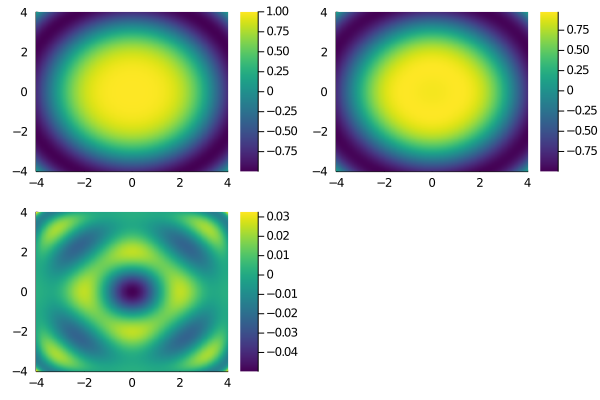

In [191]:
# define grid for plots
x = a[1]:0.05:b[1]
y = a[2]:0.05:b[2]
xy = collect(Iterators.product(x,y))

# calculate true values
v_true = g.(xy)


# reshape xy from an array to a vector and call  evaluate_interpolation
vec_xy = reshape(xy,length(xy))
v_itp = p.(vec_xy)

# convert back to grid for plot
v_itp_grid = reshape(v_itp, length(x), length(y))

# make plots
p1 = Plots.heatmap(y,x,v_true)
p2 = Plots.heatmap(y,x,v_itp_grid)
p3 = Plots.heatmap(y,x,v_itp_grid .- v_true)
plot(p1,p2,p3)#,p3,layout = 3)


# Test `BellmanOpperators.expectation` 
## tests state uncertianty propogation in observaiton model 

In [307]:
include("MvGaussHermite.jl")
include("BellmanOpperators.jl")
include("POMDPs.jl")
# initianize POMDP object
pars = (0.98,0.001, 5)
T_! = (x,f) -> Examples.unknown_growth_rate_T!(x,f,pars)
T_ = (x,f) -> Examples.unknown_growth_rate_T(x,f,pars)
R = (x,f,obs) -> 0.5*exp(x[1]+f[1]) - 1/obs[1]
Sigma_N = Examples.Sigma_N
H = (x,a,obs) -> Examples.H * x
Sigma_O = (a,obs) -> reshape(Examples.Sigma_O(obs),1,1)
delta = 0.95
unknownGrowthRate = POMDPs.init(T_!,T_,R,H,Sigma_N,Sigma_O,delta, [[0.05],[0.1],[0.15]], [[0.05],[1.0]])


# state 
act = [0.15]
obs = [1.0]

# value function 
a = [-4.0,-4.0,0.0,0.0,0.0]
b = [8.0,8.0,2.0,2.0,2.0]
m = 6
p = ValueFunctions.init_interpolation(a,b,m)
g(x) = cos(0.05*x[1]^2+0.05*x[2]^2+0.01*x[1])+0.05*x[3]-0.05*x[4]
new_values = g.(p.grid)
ValueFunctions.update_interpolation!(p, new_values)


V = (x,a) -> p(x)
x_hat = [0.4, 0.0]
x_cov = [0.2 0.0; 0.0 0.1]
s = (x_hat,x_cov)
data = BellmanOpperators.init_bellmanIntermidiate(2, 1, 8, 8)

println(BellmanOpperators.expectation!(s,act,obs, data, unknownGrowthRate, V))
println(BellmanOpperators.Bellman!(s,data,unknownGrowthRate, V))
println(BellmanOpperators.Policy!(s, data,unknownGrowthRate, V))

0.9725176652839028


0.9725176652839028
([0.15], [1.0])


In [309]:
#MC_expectation(s, act, obs, unknownGrowthRate, V, 500, 2000)
vals = broadcast(i -> BellmanOpperators.MC_expectation(s,act,obs, unknownGrowthRate,V,5000,5000), 1:2)
Plots.histogram(vals)

LoadError: [91mInterruptException:[39m

# Test timing and number of allocations 

In [54]:
#include("BellmanOpperators.jl")
BellmanOpperators.MC_expectation(s, a, obs, unknownGrowthRate, V, 500, 500)
@time BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
@time BellmanOpperators.MC_expectation(s, [a], unknownGrowthRate, V, 500, 500)

  0.001118 seconds (6.72 k allocations: 415.906 KiB)
  1.051516 seconds (6.73 M allocations: 453.072 MiB, 9.34% gc time)


2.9204279144600838

In [231]:
prod = IterTools.product([[1],[2]], [[2],[3]])

Base.Iterators.ProductIterator{Tuple{Array{Array{Int64,1},1},Array{Array{Int64,1},1}}}(([[1], [2]], [[2], [3]]))

In [236]:
reshape(collect(prod),4)

4-element Array{Tuple{Array{Int64,1},Array{Int64,1}},1}:
 ([1], [2])
 ([2], [2])
 ([1], [3])
 ([2], [3])

# Compare Monte-Carlo and guasian quadrature 

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

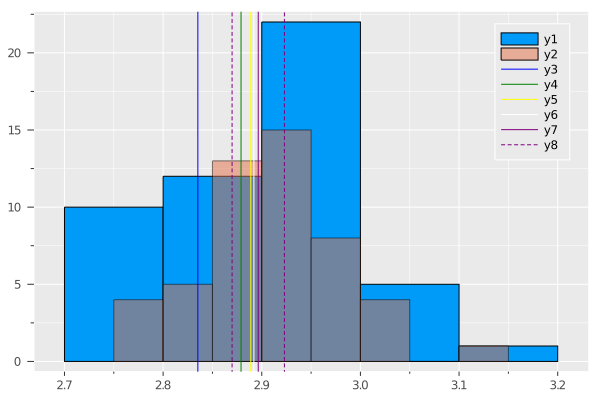

In [55]:
theme(:ggplot2)
data = BellmanOpperators.init_bellmanIntermidiate([0.1], 2, 1, 3, 3)
vals3 = BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
data = BellmanOpperators.init_bellmanIntermidiate([0.1], 2, 1, 4, 4)
vals4 = BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
data = BellmanOpperators.init_bellmanIntermidiate([0.1], 2, 1, 5, 5)
vals5 = BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
data = BellmanOpperators.init_bellmanIntermidiate([0.1], 2, 1, 10, 10)
vals10 = BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
Nmc = 50
MC_vals = zeros(Nmc)
pf_ukf_vals = zeros(Nmc)
for i in 1:Nmc
    print(i)
    print(" ")
    MC_vals[i] = BellmanOpperators.MC_expectation(s, [a], unknownGrowthRate, V, 500, 500)
    pf_ukf_vals[i] = BellmanOpperators.pf_ukf_expectation(s, [a], unknownGrowthRate, V, 500, 500)
end
Plots.histogram(MC_vals)
Plots.histogram!(pf_ukf_vals, alpha = 0.5)
Plots.vline!([vals3], color = "blue")
Plots.vline!([vals4], color = "green")
Plots.vline!([vals5], color = "yellow")
Plots.vline!([vals10], color = "white")
MC_est = sum(MC_vals)/length(MC_vals)
Mc_se = sqrt(sum((MC_vals .- MC_est).^2)./Nmc) / sqrt(Nmc)
Plots.vline!([MC_est], color = "purple")
Plots.vline!([MC_est+2*Mc_se, MC_est-2*Mc_se], color = "purple", linestyle=:dash)

┌ Warning: Replacing docs for `Main.BellmanOpperators.Policy! :: Tuple{Any,AbstractArray{Float64,1},Function,Any,Any}` in module `Main.BellmanOpperators`
└ @ Base.Docs docs/Docs.jl:227


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

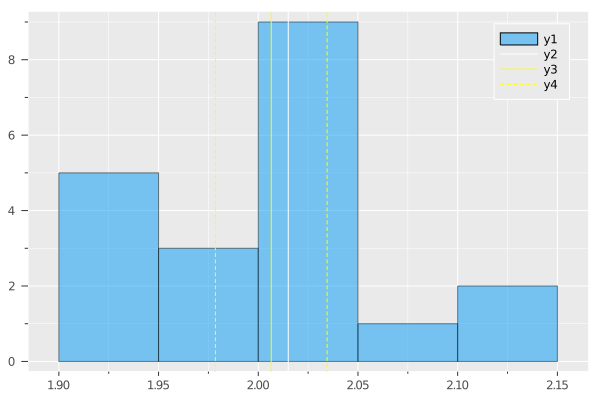

In [56]:
include("BellmanOpperators.jl")
# value function 
a = [-4.0,-4.0,0.0,0.0,0.0]
b = [8.0,8.0,2.0,2.0,2.0]
m = 6
p = ValueFunctions.init_interpolation(a,b,m)
g(x) = cos(0.15*x[1]^2+0.05*x[2]^2 + 0.2*x[1]) 
new_values = g.(p.grid)
ValueFunctions.update_interpolation!(p, new_values)

V = (x,a) -> p(x)

a = 0.1
data = BellmanOpperators.init_bellmanIntermidiate([0.1], 2, 1, 8, 8)
vals = BellmanOpperators.expectation!(data, s, [a], V, unknownGrowthRate)
Nmc = 20
MC_vals = zeros(Nmc)
for i in 1:Nmc
    print(i)
    print(" ")
    MC_vals[i] = BellmanOpperators.MC_expectation(s, [a], unknownGrowthRate, V, 500, 1000)
end
Plots.histogram(MC_vals, alpha = 0.5)
Plots.vline!([vals ], color = "white")
MC_est = sum(MC_vals)/length(MC_vals)
Mc_se = sqrt(sum((MC_vals .- MC_est).^2)./Nmc) / sqrt(Nmc)
Plots.vline!([MC_est], color = "yellow")
Plots.vline!([MC_est+2*Mc_se, MC_est-2*Mc_se], color = "yellow", linestyle=:dash)

In [57]:
include("BellmanOpperators.jl")
actions = [[0.01],[0.05],[0.1],[0.15],[0.2],[0.25],[0.3],[0.35]]
actions = broadcast(i -> [i], 0.01:0.05:0.5)
BellmanOpperators.Bellman!(data, s,actions,
                V, unknownGrowthRate)

@time BellmanOpperators.Bellman!(data, s,actions,
                V, unknownGrowthRate)

┌ Warning: Replacing docs for `Main.BellmanOpperators.Policy! :: Tuple{Any,AbstractArray{Float64,1},Function,Any,Any}` in module `Main.BellmanOpperators`
└ @ Base.Docs docs/Docs.jl:227


  0.011115 seconds (139.32 k allocations: 8.691 MiB)


2.049293189586498

In [58]:
sigma1 = 10
sigma2 = 20
cov = sqrt(sigma1*sigma2) - 0.000001
Distributions.MvNormal([0,0], [sigma1 cov; cov sigma2])


FullNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [10.0 14.142134623730952; 14.142134623730952 20.0]
)


# Test interpolation for covarinace matrix 

In [59]:
function f(mu, cov)
    v1 = mu[1] + 0.3*mu[2] + 0.1*mu[1]*mu[2]
    v1 = v1/(1+v1)
    v2 = cov[1,1] + cov[2,2]
    v2 = -0.05*v2^2
    return v1+v2+0.1*cov[1,2]
end 

f (generic function with 2 methods)

In [60]:
include("ValueFunctions.jl")
m = 5
Vf = ValueFunctions.init_guasianBeleifsInterp2d(m, [-5.0,-5.0],[5.0,5.0])
print(" ")

In [61]:
function test1!(mu)
    return 0.1*mu[2] * mu[1]^2
end 


function test2!(mu, cov)
    v = test1!(mu)
    return v - 0.1*cov[1,1] -0.1*cov[2,2] + 0.05*cov[2,1] +0.75*cov[1,1]*mu[1]
end 

test2! (generic function with 1 method)

# 

In [62]:
include("ValueFunctions.jl")
m1 = 20
m2 = 7
Vf1 = ValueFunctions.init_adjGausianBeleifsInterp(m1, m2, [-5.0,-5.0],[5.0,5.0])
print(" ")

In [63]:
v1 = 1.0*zeros(m1^2)
v2 = 1.0*zeros(m2^5)
v_mu = broadcast(i->test1!(Vf1.baseValue.grid[i]), 1:m1^2)
v_dsn = broadcast(i->test2!(Vf1.uncertantyAdjustment.nodes[i][1],Vf1.uncertantyAdjustment.nodes[i][2]), 1:m2^5)
print(" ")

In [64]:
ValueFunctions.update_base!(Vf1,v_mu)
ValueFunctions.update_adjustment!(Vf1, v_dsn)
print(" ")

In [65]:
z = zeros(5)
Vf1(z,[2.0,2.0], [0.1 0.01; 0.01 0.1])

0.9299187767024915

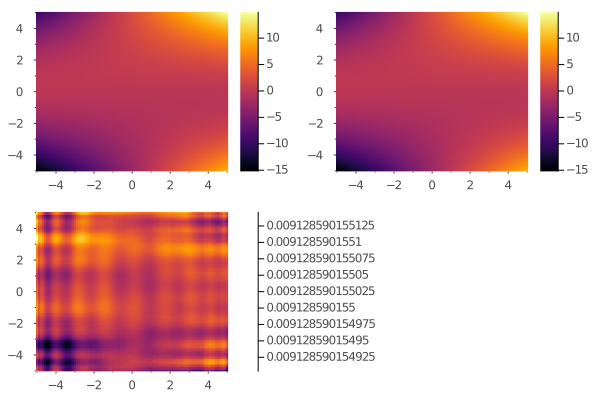

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY


In [66]:
using Plots
# define grid for plots
x = -5:0.1:5
y = -5:0.1:5
xy = collect(Iterators.product(x,y))




# reshape xy from an array to a vector and call  evaluate_interpolation
vec_xy = reshape(xy,length(xy))
v_itp = broadcast(x -> Vf1(z, [x[1],x[2]], [0.7 0.7; 0.7 1.1]), vec_xy)
v_true = broadcast(x -> test2!([x[1],x[2]], [0.7 0.7; 0.7 1.1]), vec_xy)
# convert back to grid for plot
v_itp_grid = reshape(v_itp, length(x), length(y))
v_true_grid = reshape(v_true, length(x), length(y))
# make plots
p1 = Plots.heatmap(y,x,v_true_grid)
p2 = Plots.heatmap(y,x,v_itp_grid)
p3 = Plots.heatmap(y,x,v_itp_grid .- v_true_grid)
plot(p1,p2,p3)

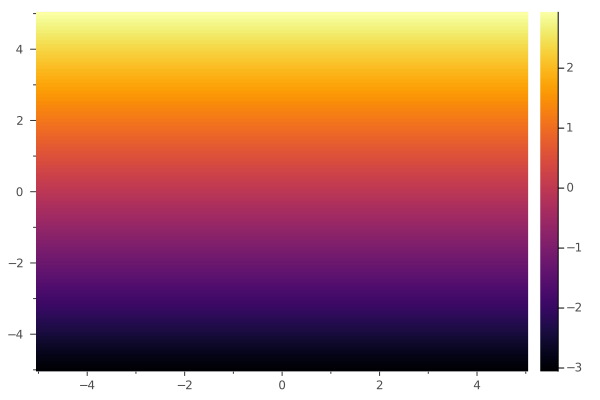

In [67]:
v_itp1 = broadcast(x -> Vf1(z, [x[1],x[2]], [1.5 0.7; 0.7 1.1]), vec_xy)
v_itp2 = broadcast(x -> Vf1(z, [x[1],x[2]], [0.7 0.7; 0.7 1.1]), vec_xy)
v_itp1_grid = reshape(v_itp1, length(x), length(y))
v_itp2_grid = reshape(v_itp2, length(x), length(y))
Plots.heatmap(y,x,v_itp1_grid  .- v_itp2_grid )

# Test Bellman operator with covariance interpolation

In [73]:
include("MvGaussHermite.jl")
include("BellmanOpperators.jl")
include("POMDPs.jl")
# initianize POMDP object
pars = Examples.unknown_growth_rate_pars
T_! = (x,f) -> Examples.unknown_growth_rate_T!(x,f,pars)
T_ = (x,f) -> Examples.unknown_growth_rate_T(x,f,pars)
R = (x,f,obs) -> 0.5*exp(x[1]+f[1]) - 1/obs[1]
R_obs = (x,f) -> Examples.unknown_growth_rate_R_obs(x,f,pars)
Sigma_N = Examples.Sigma_N
H = (x,a,obs) -> Examples.H * x
Sigma_O = (a,obs) -> reshape(Examples.Sigma_O(obs),1,1)
delta = 0.95
unknownGrowthRate = POMDPs.init(T_!,T_,R,R_obs,H,Sigma_N,Sigma_O,delta, [[0.05],[0.1],[0.15]], [[0.05],[1.0]])


# state 
act = [0.15]
obs = [1.0]

# value function 
function test1!(mu)
    return 0.1*mu[2] * mu[1]^2
end 


function test2!(mu, cov)
    v = test1!(mu)
    return v - 0.1*cov[1,1] -0.1*cov[2,2] + 0.05*cov[2,1] +0.75*cov[1,1]*mu[1]
end 

m1 = 20
m2 = 7
Vf = ValueFunctions.init_adjGausianBeleifsInterp(m1, m2, [-5.0,-5.0],[5.0,5.0])

v1 = 1.0*zeros(m1^2)
v2 = 1.0*zeros(m2^5)
v_mu = broadcast(i->test1!(Vf.baseValue.grid[i]), 1:m1^2)
v_dsn = broadcast(i->test2!(Vf.uncertantyAdjustment.nodes[i][1],Vf.uncertantyAdjustment.nodes[i][2]), 1:m2^5)

ValueFunctions.update_base!(Vf,v_mu)
ValueFunctions.update_adjustment!(Vf, v_dsn)



V = (x,a) -> p(x)
x_hat = [0.4, 0.0]
x_cov = [0.2 0.0; 0.0 0.1]
s = (x_hat,x_cov)
data = BellmanOpperators.init_bellmanIntermidiate(2, 1, 5, 5)

println(BellmanOpperators.expectation!(s,act,obs, data, unknownGrowthRate, Vf))
println(BellmanOpperators.Bellman!(s,data,unknownGrowthRate, Vf))
println(BellmanOpperators.Policy!(s, data,unknownGrowthRate, Vf))


-0.017819012222585095


-0.017819012222585095
([0.15], [1.0])


In [74]:
s = ([-3.998049880457325, -1.75672037060755], [1.2209826070230336 0.009098016141900445; 0.009098016141900445 0.04679987142611036])

println(BellmanOpperators.Bellman!(s,data,unknownGrowthRate, Vf))

-7.221003535154169


In [72]:
print(s)

([-3.998049880457325, -1.75672037060755], [1.2209826070230336 0.009098016141900445; 0.009098016141900445 0.04679987142611036])

# Test VFI on Unknown growth rate fishery model 

In [216]:
# Initialize model 
include("Examples.jl")
include("ValueFunctions.jl")
include("BeleifMDPSolvers.jl")


pars = Examples.unknown_growth_rate_pars

T_! = (x,f) -> Examples.unknown_growth_rate_T!(x,f,pars)
T_ = (x,f) -> Examples.unknown_growth_rate_T(x,f,pars)
R = (x,f,obs) -> Examples.unknown_growth_rate_R(x,f,obs,pars)
R_obs = (x,f) -> Examples.unknown_growth_rate_R_obs(x,f,pars)
Sigma_N = Examples.Sigma_N
H = (x,a,obs) -> Examples.H * x
Sigma_O = (a,obs) -> reshape(Examples.Sigma_O(obs),1,1)
delta = 0.95
actions = Examples.unknown_growth_actions
observations = Examples.unknown_growth_observations

upper = Examples.unknown_growth_upper
lower = Examples.unknown_growth_lower

solver1 = BeleifMDPSolvers.init(T_!, T_, R, R_obs, H, Sigma_N, Sigma_O,delta,actions,observations,lower,upper)
print(" ")

In [217]:
include("BeleifMDPSolvers.jl")
BeleifMDPSolvers.solve_observed(solver1)
BeleifMDPSolvers.solve(solver1)

here0 225.00225 1 178.46218859195238 2 81.36081601160846 3 110.2283889082255 4 136.3606577392552 5 147.83249272765744 6 139.22127933382598 7 124.48730584177544 8 109.89982050788247 9 96.57199776040648 10 84.83205682441115 11 74.53308016623146 12 65.49433112803402 13 57.57047488820737 14 50.624572355228274 15 44.53595239295771 16 39.198495172281746 17 34.51823192638116 18 30.412046964869745 19 26.807387445182634 20 23.641228835047688 21 20.858589357242224 22 18.411684914890493 23 16.25885881177206 24 14.363785529854516 25 12.694761796926345 26 11.2240991158256 27 9.9276012800736 28 8.784111670290036 29 7.77512020730323 30 6.8844186713129645 31 6.097806819000144 32 5.4028380449522455 33 4.788593861827833 34 4.2454914272313395 35 3.7651143886810448 36 3.340066826712534 37 2.963845988482623 38 2.6307313984173772 39 2.335688162554616 40 2.074282601456332 41 1.842608585388153 42 1.6372231690090464 43 1.4550903119374656 44 1.293531635734864 45 1.1501833085547715 46 1.0229582701411586 47 0.910

"two stage VFI: full model solved"

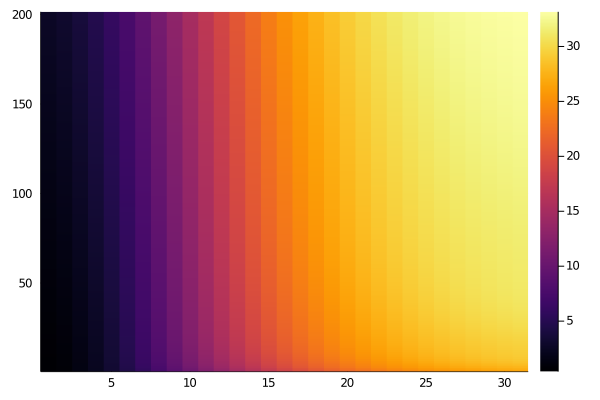

In [218]:
using Plots
lower = solver1.valueFunction.baseValue.a
upper = solver1.valueFunction.baseValue.b
mx = 200
mr = 30
dx = (exp(upper[1]) - exp(lower[1]))/mx 
dr = (exp(upper[2]) - exp(lower[2]))/mr
x_ = exp(lower[1]):dx:exp(upper[1])
r_ = exp(lower[2]):dr:exp(upper[2])
vals = zeros(mx+1,mr+1)
i = 0
for x in x_
    i +=1
    j = 0
    for r in r_
        j+=1
        vals[i,j] = solver1.valueFunction.baseValue(log.([x,r]))
    end
end 
Plots.heatmap(vals)

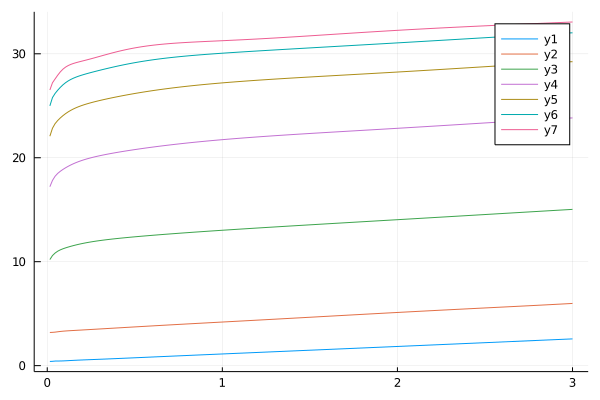

In [219]:

Plots.plot(x_, vals[:,1])
Plots.plot!(x_, vals[:,5])
Plots.plot!(x_, vals[:,10])
Plots.plot!(x_, vals[:,15])
Plots.plot!(x_, vals[:,20])
Plots.plot!(x_, vals[:,25])
Plots.plot!(x_, vals[:,30])

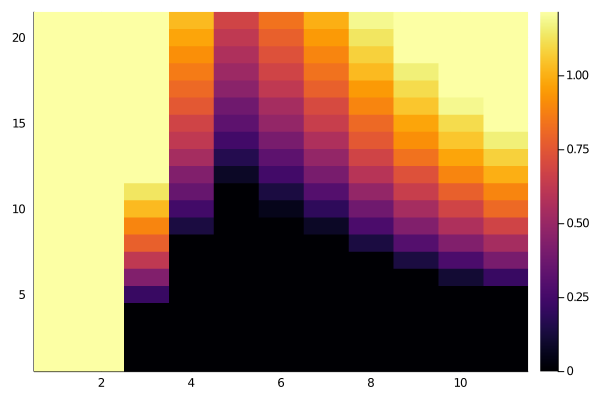

In [220]:
include("BellmanOpperators.jl")
lower = solver1.valueFunction.baseValue.a
upper = solver1.valueFunction.baseValue.b
mx = 20
mr = 10
dx = (exp(upper[1]) - exp(lower[1]))/mx 
dr = (exp(upper[2]) - exp(lower[2]))/mr
x_ = exp(lower[1]):dx:exp(upper[1])
r_ = exp(lower[2]):dr:exp(upper[2])
vals = zeros(mx+1,mr+1)
i = 0
for x in x_
    i +=1
    j = 0
    for r in r_
        j+=1
        vals[i,j] = BellmanOpperators.obs_Policy(log.([x,r]), solver1.obsBellmanIntermidiate,solver1.valueFunction.baseValue, solver1.POMDP)[1]
    end
end 
Plots.heatmap(vals)


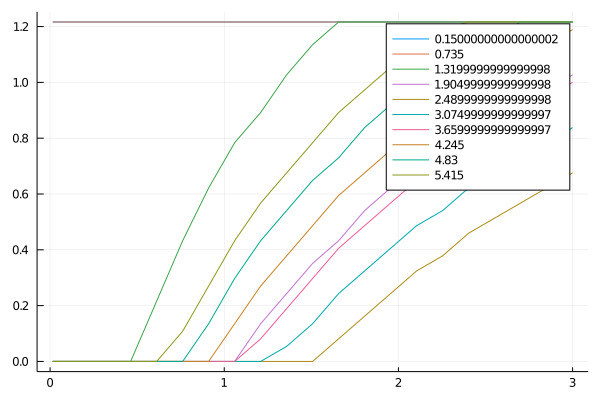

In [221]:
Plots.plot(x_, vals[:,1], label = string(r_[1]))
Plots.plot!(x_, vals[:,2], label = string(r_[2]))
Plots.plot!(x_, vals[:,3], label = string(r_[3]))
Plots.plot!(x_, vals[:,4], label = string(r_[4]))
Plots.plot!(x_, vals[:,5], label = string(r_[5]))
Plots.plot!(x_, vals[:,6], label = string(r_[6]))
Plots.plot!(x_, vals[:,7], label = string(r_[7]))
Plots.plot!(x_, vals[:,8], label = string(r_[8]))
Plots.plot!(x_, vals[:,9], label = string(r_[9]))
Plots.plot!(x_, vals[:,10], label = string(r_[10]))

In [222]:
include("BellmanOpperators.jl")
include("ValueFunctions.jl")
include("BeleifMDPSolvers.jl")
BeleifMDPSolvers.solve(solver1)

0 3128.1249999999995
0.032 0.064 0.096 0.128 0.16 

LoadError: [91mInterruptException:[39m

In [223]:
include("BellmanOpperators.jl")
s = ([-3.998049880457325, -1.75672037060755], [1.2209826070230336 0.04573896913165699; 0.04573896913165699 1.1828266132785348])
BellmanOpperators.Bellman!(s, solver1.bellmanIntermidiate,
                                        solver1.POMDP, solver1.valueFunction)

1.3188811728514869

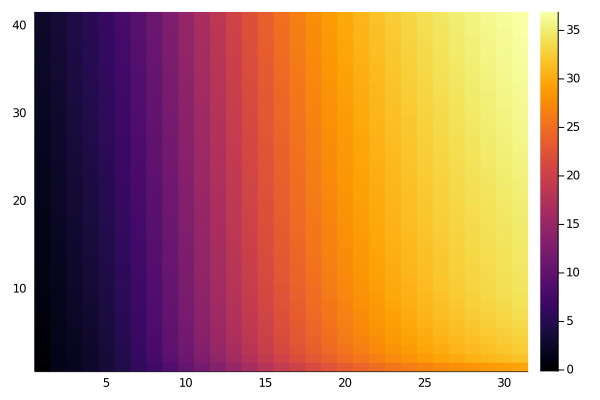

In [224]:
using Plots
lower = solver1.valueFunction.baseValue.a
upper = solver1.valueFunction.baseValue.b
mx = 40
mr = 30
dx = (exp(upper[1]) - exp(lower[1]))/mx 
dr = (exp(upper[2]) - exp(lower[2]))/mr
x_ = exp(lower[1]):dx:exp(upper[1])
r_ = exp(lower[2]):dr:exp(upper[2])
vals = zeros(mx+1,mr+1)
i = 0
for x in x_
    i +=1
    j = 0
    for r in r_
        j+=1
        vals[i,j] = solver1.valueFunction(1.0*zeros(5), (log.([x,r]), [0.01 0; 0 0.01]))
    end
end 
Plots.heatmap(vals)

In [225]:

p = Plots.plot(x_, vals[:,1], color = "black")
Plots.plot!(p,x_, vals[:,5], color = "black")
Plots.plot!(p,x_, vals[:,10], color = "black")
Plots.plot!(p,x_, vals[:,15], color = "black")
Plots.plot!(p,x_, vals[:,20], color = "black")
Plots.plot!(p,x_, vals[:,25], color = "black")
Plots.plot!(p,x_, vals[:,30], color = "black")

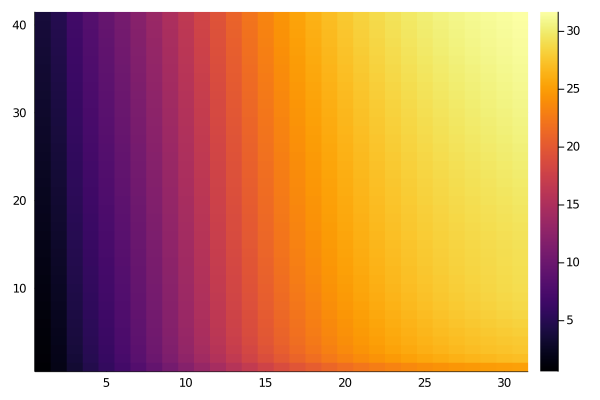

In [226]:
using Plots
lower = solver1.valueFunction.baseValue.a
upper = solver1.valueFunction.baseValue.b
mx = 40
mr = 30
dx = (exp(upper[1]) - exp(lower[1]))/mx 
dr = (exp(upper[2]) - exp(lower[2]))/mr
x_ = exp(lower[1]):dx:exp(upper[1])
r_ = exp(lower[2]):dr:exp(upper[2])
vals = zeros(mx+1,mr+1)
i = 0
for x in x_
    i +=1
    j = 0
    for r in r_
        j+=1
        vals[i,j] = solver1.valueFunction(1.0*zeros(5), (log.([x,r]), [0.5 0.49; 0.49 0.5]))
    end
end 
Plots.heatmap(vals)

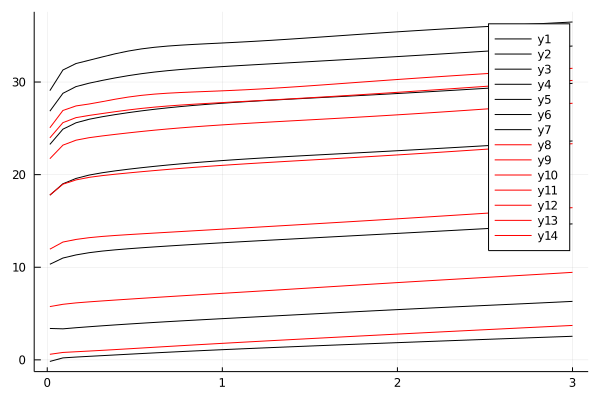

In [227]:

Plots.plot!(p,x_, vals[:,1], color = "red")
Plots.plot!(p,x_, vals[:,5], color = "red")
Plots.plot!(p,x_, vals[:,10], color = "red")
Plots.plot!(p,x_, vals[:,15], color = "red")
Plots.plot!(p,x_, vals[:,20], color = "red")
Plots.plot!(p,x_, vals[:,25], color = "red")
Plots.plot!(p,x_, vals[:,30], color = "red")